## Estimate weight of long range edges using appropriate penalizations for likelihoods

### Two models: 
1. instantantenous admixture (akin to TreeMix/SpaceMix model) - assume a single long range edge from $s$ to $d$ with some shared portion of the genome $c$. So, then $L^{\dagger_n}_{s,d} = (1-c) \times L^{\dagger_o}_{s,d} + c \times L^{\dagger_o}_{s,s}$

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed

# viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import seaborn as sns

# feems
import sys
sys.path.append('../../')
from feems import SpatialGraph, Viz, Objective
from feems.joint_ver import FEEMSmix_SpatialGraph, FEEMSmix_Objective, loss_wrapper
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes, simulate_genotypes_w_admixture
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv, run_cvq, run_cv_joint
from feems.helper_funcs import * 

# popgen
# import msprime
# import tskit
import allel

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})
plt.rcParams['axes.axisbelow'] = True
plt.style.use('bmh')
rng = np.random.default_rng(2022)

## Creating a function to calculate Wishart likelihood from a matrix of pairwise resistance distances 

Easier to model $R$ as as function of admixture proportion $c$ instead of modeling $L^\dagger$ as a function of $c$ 

In [76]:
def get_FEEMS_demes_ll_w_c(sp_graph, obj, lrn, c, df=100, sigstar=1):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, df, -sigstar/df*C @ resmat @ C.T), sp.stats.linregress(np.ravel(2*C @ sp_graph.S @ C.T), np.ravel(-C @ resmat @ C.T))[2]**2
    # return sp.stats.wishart.logpdf(-C @ resmat @ C.T, df, 2*C @ sp_graph.S @ C.T) 

def get_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn, form='element'):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T
    
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    if(form!='matrix'):
        ##-----------------using the element-wise formulation----------------------##
        ## sd
        ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    else:
        ##-----------------using the matrix formulation----------------------##
        BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

        ## sd
        BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
        BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
        ## id
        for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            #id
            BR1[i,lrn[0][1]] = 1-c
            BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
            # sd
            BR2[i,lrn[0][1]] = c
            BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
            # is
            BR3[i,lrn[0][1]] = 0.5*(c**2-c)
            BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

        BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

        BQ1[lrn[0][0],lrn[0][1]] = 1+c
        BQ1[lrn[0][1],lrn[0][0]] = 1-c

        Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
        for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
            Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

            Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
            Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

            Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
            Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

            Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
            Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

        resmat = np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q)

    # return resmat
    D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S
    # plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
    # plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
    # plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
    # plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)
    return -sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)

In [2]:
## writing code to pass in gradient wrt c (using scipy.optimize.minimize)
## this is basic code to check if the analytical derivative was found correctly and if I can code it up correctly 
def get_grad_FEEMS_demes_nll_w_c(c, opts):
    sp_graph = opts['sp_graph']; lrn = opts['lrn']

    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*opts['obj'].Linv + np.reshape(np.diag(opts['obj'].Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(opts['obj'].Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
    BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

    ## sd
    BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
    BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
    ## id
    for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        #id
        BR1[i,lrn[0][1]] = 1-c
        BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
        # sd
        BR2[i,lrn[0][1]] = c
        BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
        # is
        BR3[i,lrn[0][1]] = 0.5*(c**2-c)
        BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

    BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); #BQ2 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    BQ1[lrn[0][0],lrn[0][1]] = 1+c
    BQ1[lrn[0][1],lrn[0][0]] = 1-c

    Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
        Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

        Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
        Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

        Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
        Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

        Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
        Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

    resmat = -0.5*(np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q))

    ## construct derivative vectors
    ## using version from FEEMS appendix
    delldsig = sp_graph.n_snps * (C.T@(np.linalg.inv(C@resmat@C.T)@(C@sp_graph.S@C.T)@np.linalg.inv(C@resmat@C.T)-np.linalg.inv(C@resmat@C.T))@C).reshape(1,-1)
    
    dsigdc = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes))
    dsigdc[lrn[0][0],lrn[0][1]] = (c-1.5)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[lrn[0][0]] - 1/sp_graph.q[lrn[0][1]]
    dsigdc[lrn[0][1],lrn[0][0]] = dsigdc[lrn[0][0],lrn[0][1]]
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        dsigdc[i,lrn[0][1]] = -Rmat[i,lrn[0][1]] + Rmat[i,lrn[0][0]] + (c-0.5)*Rmat[lrn[0][0],lrn[0][1]] - 1/sp_graph.q[lrn[0][1]] + 1/sp_graph.q[lrn[0][0]]
        dsigdc[lrn[0][1],i] = dsigdc[i,lrn[0][1]]

    # dBR1 = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); dBR2 = np.zeros_like(dBR1); dBR3 = np.zeros_like(dBR1)
    # dBR1[lrn[0][0],lrn[0][1]] = c-1.5
    # dBR1[lrn[0][1],lrn[0][0]] = dBR1[lrn[0][0],lrn[0][1]]
    # ## id
    # for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
    #     #id
    #     dBR1[i,lrn[0][1]] = -1
    #     dBR1[lrn[0][1],i] = dBR1[i,lrn[0][1]]
    #     # sd
    #     dBR2[i,lrn[0][1]] = 1
    #     dBR2[lrn[0][1],i] = dBR2[i,lrn[0][1]]
    #     # is
    #     dBR3[i,lrn[0][1]] = c-0.5
    #     dBR3[lrn[0][1],i] = dBR3[i,lrn[0][1]]

    # dBQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    # dBQ1[lrn[0][0],lrn[0][1]] = 1
    # dBQ1[lrn[0][1],lrn[0][0]] = -1

    # dresmat = np.multiply(dBR1,Rmat) + np.multiply(dBR3,Rsdmat) + np.multiply(dBQ1,Q1mat) + np.multiply(Q1mat.T,dBQ1.T) + np.multiply(dBR2,Rismat+Qismat-Qidmat)
    # dsigdc = dresmat.reshape(-1,1)


    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, 1/sp_graph.n_snps*C @ resmat @ C.T)#, np.ravel(delldsig @ dsigdc.reshape(-1,1))[0]

In [3]:
def get_FEEMS_udemes_nll_w_c(c, sp_graph, obj, lrn):
    '''Here, we are modeling the admixture est. framework between an unsampled deme (1) & a sampled deme (d)'''
    # sp_graph = opts['sp_graph']; obj = opts['obj']; lrn = opts['lrn'] # (1, d, s)
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T); resmat[np.diag_indices(sp_graph.n_observed_nodes)] = 0 #- 2*sp_graph.q_inv_diag

    # need to compute pseudo-inverse of L_{d x d}
    Lpinv = np.linalg.pinv(sp_graph.L.todense())  

    neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
    ## only for sampled neighboring nodes 
    neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

    R1d = -2*Lpinv[lrn[0][0],lrn[0][1]] + Lpinv[lrn[0][0],lrn[0][0]] + Lpinv[lrn[0][1],lrn[0][1]]

    for s in neighs:
        # convert back to appropriate indexing excluding the unsampled demes
        s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==s][0]
        resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

    # closest sampled deme is the proxy source for the unsampled deme
    proxs = np.argmin([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set([k for k, v in nx.get_node_attributes(sp_graph,'n_samples').items() if v>0])-set([lrn[0][0]])])
    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
        Ri1 = -2*Lpinv[i,lrn[0][0]] + Lpinv[i,i] + Lpinv[lrn[0][0],lrn[0][0]]
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[proxs]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)

In [10]:
# obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
# obj.neg_log_lik_c(0,{'lre':[(9,0)],'mode':'sampled'}), obj.joint_neg_log_lik_c(np.r_[np.log(sp_graph.w),np.log(sp_graph.q),sp_graph.c,sp_graph.t],{'lre':[(9,0)]})
# obj.neg_log_lik(), obj.neg_log_lik_c_t([0.55,0.00],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.55,{'lre':[(22,57)],'mode':'sampled'}),
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.05)],method='Nelder-Mead') #14891
# plt.imshow(obj.Linv-obj_nomu.Linv,cmap='RdBu'); plt.colorbar()
# plt.plot(1/sp_graph.q, 1/sp_graph_nomu.q, 'ko'); plt.axline((0,0),slope=1)
# plt.plot(sp_graph.w, sp_graph_nomu.w, 'ko'); plt.axline((0,0),slope=1)
# obj_nomu.extract_outliers(pthresh=0.01)
# plt.plot(sp_graph.w, np.exp(newres[0][:sp_graph.size()]),'ko')
# newres[1], obj.neg_log_lik_c_t([0.5,0.0],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.5,{'lre':[(22,57)],'mode':'sampled'})
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.3,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)])
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.5,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)])
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.7,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)]); 

In [471]:
# plt.hist(1/sp_graph.q,bins=10); plt.show(); plt.hist(sp_graph.w,bins=20); plt.show()
# sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1., option='bothct', long_range_edges=[(23,56)])
# newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),obj.sp_graph.c],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e10,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)])
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-1]), newres[0][-1])
# newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c_t,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),0.5,1e-2],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e7,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)]+[(0,0.2)])
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-2]), newres[0][-2:])
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.26,0.00],args=({'lre':[(22,57)]}),method='Nelder-Mead',bounds=[(0,1),(0,0.03)]), sp.optimize.minimize(obj.neg_log_lik_c,x0=0.2,args=({'lre':[(22,57)],'mode':'sampled'}),method='L-BFGS-B',bounds=[(0,1)]), newres[1], obj.neg_log_lik_c_t([0.5,0.001],{'lre':[(22,57)]}),obj.neg_log_lik_c(0.09,{'lre':[(22,57)],'mode':'sampled'}) # 13401
# sp.optimize.minimize(obj.neg_log_lik_c,x0=0.2,args=({'lre':[(22,57)],'mode':'sampled'})), sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.22,1e-4],args=({'lre':[(22,57)]}),method='L-BFGS-B',bounds=[(0,1),(0,0.2)])
# obj.joint_neg_log_lik_c(np.r_[np.log(sp_graph.w),np.log(sp_graph.s2),0.29],{'lre':[(22,57)]})
# obj.joint_neg_log_lik_c_t(np.r_[np.log(sp_graph.w),np.log(sp_graph.s2),0.6,0.01],{'lre':[(22,57)]}) #
# -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T), -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat_hao @ C.T)
# sp_graph.c, sp_graph.t
# ?sp.optimize.fmin_l_bfgs_b
# plt.hist(1/sp_graph.q); plt.axvline(1/sp_graph.q[56],color='red')
# plt.hist(1/sp_graph.q,bins=10); plt.show(); plt.hist(sp_graph.w,bins=20)

(19185.890670274996, 19185.890670274996)

In [311]:
n_rows, n_columns = 8, 10
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1, barrier_w=1, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=6, n_samples_per_node=15)
# gen_test_2 = simulate_genotypes_w_admixture(graph_def, target_n_snps=800, n_print=700, long_range_nodes=[(22,57)], admixture_props=[0.0], time_of_adm=[100], n_e=1, dump=False)
# sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
# %time sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1.); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); #oldw = sp_graph.w; olds2 = sp_graph.s2
# df = obj.extract_outliers(0.01,verbose=False)
# plt.plot(oldw,np.exp(newres[0][:sp_graph.size()]),'ko',alpha=0.5); plt.axline((1,1),slope=1,color='grey'); plt.xlabel(r'$\hat w$ before joint optimization'); plt.ylabel(r'$\hat w$ after')
# plt.plot(olds2,np.exp(newres[0][sp_graph.size():-2]),'ko',alpha=0.5); plt.axline((1,1),slope=1,color='grey'); plt.plot(olds2[57],np.exp(newres[0][sp_graph.size():-2])[57],'r*'); plt.xlabel(r'$\hat \sigma^2$ before joint optimization'); plt.ylabel(r'$\hat \sigma^2$ after')
# np.exp(newres[0][sp_graph.size():-1])
# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, abs_max=0.25,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# sp_graph.fit(lamb=3., optimize_q=None, option='onlyc', long_range_edges=[(23,56)]); sp_graph.c
# sp_graph.q
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
# emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
# X = sm.add_constant(fit_dist)
# mod = sm.OLS(emp_dist, X)
# res = mod.fit()
# muhat, betahat = res.params
# plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.5, markersize=4); plt.axline((0,muhat), slope=betahat, color='orange', ls='--', lw=3)
# plt.text(1, 0.5, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,2)), fontsize=15); plt.xlabel('fit distance'); plt.ylabel('empirical distance')

# lle, te = get_best_lre(sp_graph, gen_test_2, coord_def, grid_def, edge_def, k=2, top=5, nchoose=100, option='hard')
# defw = sp_graph.w; defq = sp_graph.q
# obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# gr = obj.grad_obj 
# sp_graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='joint', long_range_edges=[(23,56)], c=0.2); #sp_graph.fit(lamb=3., optimize_q='n-dim', option='onlyc', long_range_edges=[(23,56)], c=0.2) 
# jtw = sp_graph.w; jtq = sp_graph.q
# obj = Joint_Objective(sp_graph, option= 'joint'); obj.inv(); obj.grad(reg=False)
# grjt = obj.grad_obj
# plt.plot(defw, jtw, 'ko'); plt.plot(defw,defw,ls='-',color='grey'); plt.xlabel('default weights'); plt.ylabel('weights with $c=0$'); plt.show()
# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey'); plt.xlabel('default $q$'); plt.ylabel('$q$ with $c=0$')
# plt.plot(gr, grjt, 'ko'); plt.plot(gr,gr,ls='-',color='grey'); plt.xlabel('gradient of obj (default)'); plt.ylabel('gradient of obj (with $c=0$)')

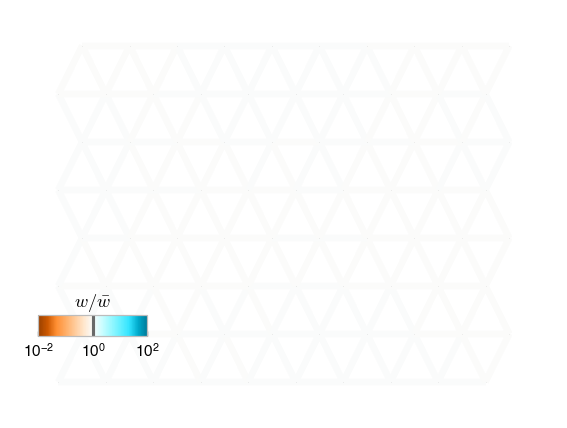

In [1171]:
fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, obj, projection=ccrs.Mercator(), edge_width=4, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=12, cbar_ticklabelsize=10)
v.draw_edges(use_weights=True); v.draw_edge_colorbar(); 
# ax.scatter(v.grid[53,0],v.grid[53,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');
for i in range(sp_graph.n_observed_nodes):
        ax.scatter(v.grid[i,0],v.grid[i,1],marker='o',color='grey',s=15/sp_graph.q[i])

# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey');
# plt.plot(jtw0, jtw, 'ko'); plt.plot(defq,defq,ls='-',color='grey');

In [230]:
# list(sp_graph.neighbors(23))
# list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[75]))
# neighs = [22,11,14,23] 
# [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]
# nx.get_node_attributes(sp_graph,'permuted_idx')[74]
# get_best_lre(sp_graph,k=1, lamb_cv=3., top=10, nboot=20, nchoose=100, option='base')
# MLEloc60
# MLEdist60 = [2, 0, 2, 1, 2, 2, 2, 2, 2, 0]; MLEdist = [3, 4, 0, 2, 1, 2, 3, 4, 0, 2]
# plt.scatter(range(1,11),np.sort(MLEdist)[::-1],color='lightblue',marker='D',s=75,label=r'$c=0.3$'); plt.yticks(range(5)); plt.ylabel('dist. from true deme'); plt.xlabel('replicate'); plt.scatter(range(1,11),np.sort(MLEdist60),color='dodgerblue',marker='o',label=r'$c=0.6$'); plt.legend()
# plt.scatter([3,5,9],np.array(MLEdist60)[np.array([2,4,8])],color='lightblue',marker='D'); 
# plt.scatter([2,4,10],np.array(MLEdist60)[np.array([1,3,9])],color='dodgerblue',marker='D',s=55);

# res60 = np.polyfit(np.abs(MLEc60-0.6),truell60,1); res = np.polyfit(np.abs(MLEc-0.3),truell,1)
# plt.scatter(np.abs(MLEc60-0.6),truell60,color='dodgerblue',alpha=0.8,label=r'$c=0.6$, mean dist.≈1.5',s=(np.array(MLEdist60)+1)*70); plt.xlabel(r'$|c-\hat c|$'); plt.ylabel('log-lik difference b/w MLE & true deme'); plt.scatter(np.abs(MLEc-0.3),truell,color='lightblue',label=r'$c=0.3$, mean dist.≈2.1',s=(np.array(MLEdist)+1)*70); plt.legend()
# plt.plot(np.abs(MLEc60-0.6),np.abs(MLEc60-0.6)*res60[0]+res60[1],color='dodgerblue'); plt.plot(np.abs(MLEc-0.3),np.abs(MLEc-0.3)*res[0]+res[1],color='lightblue'); 

# plt.boxplot(np.vstack((MLEc,MLEc60)).T,labels=['0.3','0.6']); plt.ylabel(r'$\hat c$'); plt.title('MLE deme'); plt.axhline(0.3,color='grey',linestyle='--'); plt.axhline(0.6,color='grey',linestyle='--'); plt.ylim(0,1); plt.show();
# plt.boxplot(np.vstack((truec,truec60)).T,labels=['0.3','0.6']); plt.ylabel(r'$\hat c$'); plt.title('true deme'); plt.axhline(0.3,color='grey',linestyle='--'); plt.axhline(0.6,color='grey',linestyle='--'); plt.ylim(0,1)
# plt.scatter(range(1,11),MLEdist,color='k',marker='x',s=np.abs(MLEc60-0.6)*400,label='sampled demes'); plt.yticks(range(5)); plt.plot([2,4,10],np.array(MLEdist)[np.array([1,3,9])],'ko',label='unsampled demes'); plt.legend(); plt.ylabel('dist. from true deme'); plt.xlabel('replicate')
# plt.scatter(range(1,11),truell60,color='dodgerblue',marker='o',s=np.abs(truec60-0.6)*400); plt.xlabel('replicate'); plt.ylabel('log-lik difference b/w MLE & true deme'); plt.scatter(range(1,11),truell,color='lightblue',marker='o',s=np.abs(truec-0.3)*400); plt.xlabel('replicate'); plt.ylabel('log-lik difference b/w MLE & true deme')
# np.sum(np.abs(MLEc60-0.6)), np.sum(np.abs(truec60-0.6))
# plt.boxplot(np.vstack((MLEc60, truec60)).T); plt.ylim(0,1); plt.axhline(0.6)
# sampnodes = [2,14,18,25,31,44,46,57,62,66,74]
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=10, corridor_w=1., barrier_w=1., barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=6, option=1, ss=15)
# gen_test_80 = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=50, long_range_nodes=[(44,17)], admixture_props=[0.0], n_e=np.linspace(1,8,80,endpoint=True), time_of_adm=[0])
# coord = coord_def[list(range(220))+list(range(230,410)),:]
# gen_test = gen_test_80[list(range(220))+list(range(230,410)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)
# sp_graph = FEEMSmix_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=30.); 
# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# obj.extract_outliers(0.001); obj.inv(); obj.Lpinv = np.linalg.pinv(sp_graph.L.todense()); obj.grad(reg=False)
# df = obj.calc_contour(destid=18,search_area='all',exclude_boundary=True)
# sampnodes = list(np.arange(1,81)[::2])+[44]
# sampnodes = [2,18,25,31,44,46,57,62,74]
# sampnodes = [2,14,18,25,31,44,46,57,62,66]
# ss = [np.random.randint(1,11)*2 if i in sampnodes else 0 for i in range(80)]
# np.array(ss)[np.array(sampnodes)]
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=10, corridor_w=1, barrier_w=1, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=6, option=2, ss=[20 if i in sampnodes else 0 for i in range(80)])
# foo = lambda c: simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=500, long_range_nodes=[(44,17)], admixture_props=[0.5], n_e=100, time_of_adm=[100])
# gen_test_80 = Parallel(n_jobs=16)(delayed(foo)(0.5) for _ in range(16))

((800, 2), (1200, 1000))

In [195]:
# MLEloc60 = np.zeros(10); MLEc60 = np.zeros(10); truell60 = np.zeros(10); truec60 = np.zeros(10)
MLEloc = []; MLEdiff = []; MLEdf = pd.DataFrame(0, index=range(1,80), columns=['(source, dest.)','admix. prop.','log-lik','scaled log-lik']); MLEc = []; MLEct = []; truect = []
cnt = 0
for i in range(16):
    # coord = coord_def[list(range(220))+list(range(230,400)),:] #-> sparse sampling with only 10 nodes
    # coord = coord[list(range(19))+list(range(20,36)),:]
    coord = coord_def[list(range(220))+list(range(230,410)),:]
    gen_test = gen_test_80[i][list(range(220))+list(range(230,410)),:]
    # gen_test = gen_test[list(range(19))+list(range(20,36)),:]
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    sp_graph = FEEMSmix_SpatialGraph(gen_test, coord, grid_def, edge_def)
    sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=30., verbose=False); 
    obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    top = obj.extract_outliers(0.001,verbose=False)
    df = obj.calc_contour(destid=17,search_area='all',exclude_boundary=False)

    # MLEloc.append(df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])])
    MLEloc.append(sp_graph.nodes[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]]['pos'])
    MLEc.append(df['admix. prop.'].iloc[np.argmax(df['scaled log-lik'])])
    MLEdiff.append(df['scaled log-lik'].iloc[np.where(df['(source, dest.)']==(44,17))[0]].values[0])

    if df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]%2:
        MLEct.append(sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0][0],8)],'mode':'sampled'},method='L-BFGS-B',bounds=[(0,1),(0,0.005)]).x)
    else:
        MLEct.append(sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0][0],8)],'mode':'unsampled'},method='L-BFGS-B',bounds=[(0,1),(0,0.005)]).x)
    truect.append(sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(62,8)],'mode':'unsampled'},method='L-BFGS-B',bounds=[(0,1),(0,0.005)]).x)
    
    MLEdf['(source, dest.)'] = df['(source, dest.)']
    MLEdf['admix. prop.'] += df['admix. prop.']
    MLEdf['scaled log-lik'] += df['scaled log-lik']
    MLEdf['log-lik'] += df['log-lik']
    if df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])]==(44,17):
        cnt += 1 

    # isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
    # for ie, e in enumerate(randedge):
    #     if e[0]<39:
    #         res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
    #         isc2[ie] = res.x; llc2[ie] = res.fun
    #     else:
    #         res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
    #         isc2[ie] = res.x; llc2[ie] = res.fun

    # MLEloc60[i] = np.argmin(llc2); MLEc60[i] = isc2[np.argmin(llc2)]
    # truell60[i] = np.min(llc2)-llc2[50]; truec60[i] = isc2[50]
    # print(MLEloc60[i], truell60[i], MLEc60[i], truec60[i])
    
    # fig = plt.figure(dpi=110)
    # ax = fig.add_subplot(1, 1, 1)
    # v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
    #         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
    # ax.scatter(v.grid[23,0],v.grid[23,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');
    # ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); 
    # CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); ax.clabel(CS, inline=1, fontsize=8, colors='k')
    # fig = plt.figure(dpi=110)
    # ax = fig.add_subplot(1, 1, 1)
    # v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, obs_node_zorder=2,
    #         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=4, sample_pt_color="black", cbar_font_size=10)
    # ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-100,-20,-10,-2,0],extend='max',cmap='Greens',alpha=0.7); CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-100,-20,-10,-2,0],cmap='Greens',alpha=0.7); ax.clabel(CS, inline=1, fontsize=8, colors='k')
    # ax.scatter(v.grid[23,0],v.grid[23,1],marker='x',color='b'); ax.scatter(v.grid[56,0],v.grid[56,1],marker='x',color='b');
MLEdf['admix. prop.'] /= 16
MLEdf['scaled log-lik'] /= 16
MLEdf['log-lik'] /= 16
MLEdf['scaled log-lik'] -= np.max(MLEdf['scaled log-lik'])
print('True source is MLE: {:d} times'.format(cnt))

Using a significance threhsold of 0.001:

1 outlier deme pairs found
 source  dest.     source (lat., long.)       dest. (lat., long.)     pval
     43     77 (2.598076211353316, 8.5) (1.7320508075688772, 1.0) 0.000152

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
77    1
Name: dest., dtype: int64
Optimizing likelihood over 79 demes in the graph...
0%...25%...50%...75%...Using a significance threhsold of 0.001:

3 outlier deme pairs found
 source  dest.     source (lat., long.)       dest. (lat., long.)     pval
     61     49 (2.598076211353316, 0.5) (1.7320508075688772, 4.0) 0.000231
      7     61 (2.598076211353316, 0.5)                (0.0, 3.0) 0.000549
     39     61 (2.598076211353316, 0.5) (0.8660254037844386, 9.5) 0.000851

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
61    2
49    1
Name: dest., dtype: int64
Optimizing likelihood over 79 demes in the graph...
0%...25%.

In [143]:
# plt.plot([1e-4,1e-3,1e-2,0.05,0.1,0.25,0.5,1],[0.13019761197484192,0.12902149935293244,0.1525418528222208,0.2596411144597768,0.3533682636707458,0.6133418878657412,1.0252415513544038,1.7361586277801393],'ko'); plt.axline((1,1),slope=1,color='grey',ls='--')
# plt.errorbar([1e-4,1e-3,1e-2,0.05,0.1,0.25,0.5,1],[0.13019761197484192,0.12902149935293244,0.1525418528222208,0.2596411144597768,0.3533682636707458,0.6133418878657412,1.0252415513544038,1.7361586277801393],yerr=2*np.array([0.022712280888398006,0.02512421169863045,0.027121704897425686,0.04519398722241161,0.04100375527102841,0.0613764922651444,0.09075075842841175,0.14649618822602764]),color='k'); plt.xlabel('msprime simulated weights'); plt.ylabel('FEEMS estimated weights'); plt.semilogx()
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])]],'mode':'unsampled'},method='Nelder-Mead',bounds=[(0,1),(0,0.005)])
# sp.optimize.minimize(obj.neg_log_lik_c, 0.5, bounds=[(0.0,1)], args={'lre':[(46,8)],'mode':'unsampled'})
# np.where(MLEdf['scaled log-lik'].isna())
# plt.hist2d(np.array(MLEloc)[:,0],np.array(MLEloc)[:,1],cmap='Greens'); plt.ylim((0,6.5)); plt.xlim((0,10)); plt.colorbar()
# (np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0][0],8)

Text(0.5, 1.0, 'True source is MLE: 14 times')

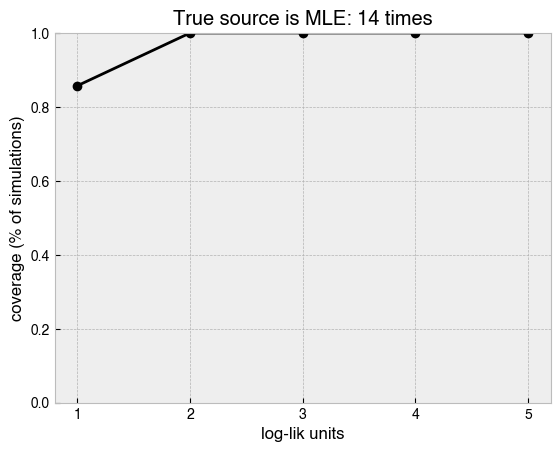

In [205]:
# n_rows, n_columns = 6, 6
# for w in [1e-2]:
#     graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=w, barrier_w=w, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=3, barrier_endpt=6, option=1, ss=20)
#     gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=900, mu=1, long_range_nodes=[(0,1)], admixture_props=[0.0], time_of_adm=[0.000001])
#     sp_graph = FEEMSmix_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def)
#     sp_graph.fit(lamb=3.,optimize_q='n-dim');   
#     print(np.mean(sp_graph.w), np.std(sp_graph.w))
# plt.plot(range(79),MLEdf['scaled log-lik'],'-o'); plt.ylim((-10,0))
# plt.plot(range(1,6),[np.sum(np.array(MLEdiff)>-l)/16 for l in range(1,6)],'-ko'); plt.xlabel('log-lik units'); plt.ylabel('coverage (% of simulations)'); plt.xticks(range(1,6)); plt.ylim(0,1); plt.title('True source is MLE: {:d} times'.format(cnt))
plt.plot(range(1,6),[12/14,1,1,1,1],'-ko'); plt.xlabel('log-lik units'); plt.ylabel('coverage (% of simulations)'); plt.xticks(range(1,6)); plt.ylim(0,1); plt.title('True source is MLE: {:d} times'.format(14))
# neighs = list(obj.sp_graph.neighbors(nx.get_node_attributes(obj.sp_graph,'permuted_idx')[47]))
# [s for s in neighs if nx.get_node_attributes(obj.sp_graph,'n_samples')[s]>0]
# np.argmin([nx.shortest_path_length(obj.sp_graph,source=7,target=d) for d in set([k for k, v in nx.get_node_attributes(obj.sp_graph,'n_samples').items() if v>0])-set([7])])
# R1 = -2*obj.Linv[48,:obj.sp_graph.n_observed_nodes] + np.diag(obj.Linv) + obj.Lpinv[48,48]
# np.argsort(R1), np.argsort([nx.shortest_path_length(obj.sp_graph,source=48,target=d) for d in set([k for k, v in nx.get_node_attributes(obj.sp_graph,'n_samples').items() if v>0])-set([48])])[:9] # {2, 14, 18, 25, 31, 46, 57, 62, 66}
# R1
# [nx.shortest_path_length(obj.sp_graph,source=44,target=d) for d in set([k for k, v in nx.get_node_attributes(obj.sp_graph,'n_samples').items() if v>0])-set([44])]

constant-w/variance fit, converged in 128 iterations, train_loss=50435.004
lambda=3.000, alpha=2.8592, converged in 104 iterations, train_loss=49718.786


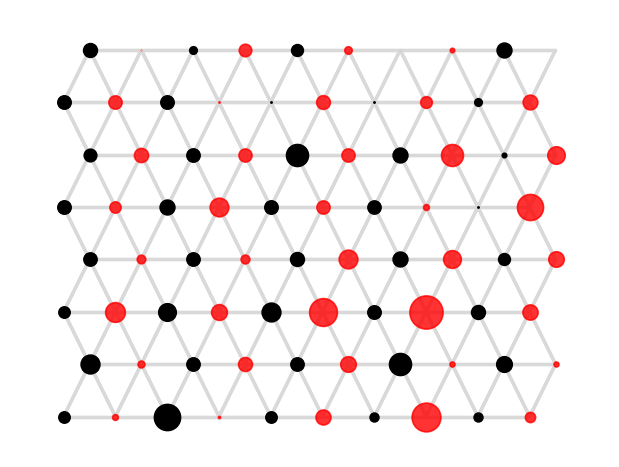

In [153]:
# np.array(MLEloc).std(axis=0)
# np.array(MLEloc).std(axis=0), np.array(MLEloc).mean(axis=0)
sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=0.)
fig = plt.figure(dpi=120)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, obj, projection=None, edge_width=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False); #v.draw_edge_colorbar()
for i in range(80):
    ip = np.where(obj.perm_idx==i)[0][0]
    if ip<sp_graph.n_observed_nodes:
        v.ax.plot(v.grid[i,0], v.grid[i,1], 'ro', alpha=0.8, markersize=20/sp_graph.q[ip])
        # v.ax.plot(v.grid[i,0], v.grid[i,1], 'ro', alpha=0.8, markersize=np.linspace(1,8,80,endpoint=True)[i])#np.concatenate((np.repeat(1,30), np.repeat(10,25), np.repeat(100,25)))[i]/5)
    else:
        R1 = np.array(-2*obj.Lpinv[:sp_graph.n_observed_nodes,ip].T + np.diag(obj.Linv) + obj.Lpinv[ip,ip])
        proxs = np.argsort([nx.shortest_path_length(sp_graph,source=ip,target=d) for d in set(obj.perm_idx[:sp_graph.n_observed_nodes])-set([ip])])[:1]
        # qprox = np.dot(1/sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
        qprox = np.dot(1/sp_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
        v.ax.plot(v.grid[i,0], v.grid[i,1], 'ko', markersize=20*qprox)
        # v.ax.plot(v.grid[i,0], v.grid[i,1], 'ko', alpha=0.8, markersize=np.concatenate((np.repeat(1,20), np.repeat(3,20), np.repeat(10,20), np.repeat(30,20)))[i])

In [103]:
# plt.plot(np.concatenate((np.repeat(1,30), np.repeat(10,25), np.repeat(100,25))),1/sp_graph.q,'ro'); plt.xlabel(r'simulated $N_e$'); plt.ylabel(r'$1/\hat q$'); plt.semilogx()
# plt.plot(np.arange(1,81),1/sp_graph.q,'ro'); plt.xlabel(r'simulated $N_e$'); plt.ylabel(r'$1/\hat q$'); 
# np.mean(sp_graph.q)

# sp.stats.linregress(np.concatenate((np.repeat(1,30), np.repeat(10,25), np.repeat(100,25))),1/sp_graph.q,)
# print(sp.stats.linregress(np.arange(1,81),1/sp_graph.q))

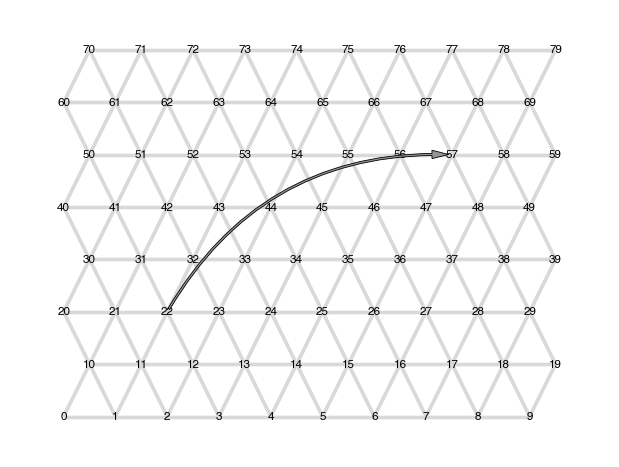

In [298]:
# sp_graph.fit(lamb=0.01,optimize_q='n-dim',lamb_q=30.)

# from matplotlib.patches import Ellipse
fig = plt.figure(dpi=120)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, obj, projection=None, edge_width=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False); v.draw_obs_nodes(use_ids=True); #v.draw_edge_colorbar()
v.draw_arrow([(22,57)],0.5)
# v.draw_ll_contour(MLEdf,levels=[-5,0]); 
# v.ax.plot(np.array(MLEloc).mean(axis=0)[0], np.array(MLEloc).mean(axis=0)[1], '*', color='darkgreen', markersize=10)
# v.ax.add_patch(Ellipse(np.array(MLEloc).mean(axis=0), width=2*np.array(MLEloc).std(axis=0)[0], height=2*np.array(MLEloc).std(axis=0)[1], alpha=0.5, facecolor='lightgreen'))
# v.ax.plot(v.grid[44,0],v.grid[44,1],'rx'); #v.draw_arrow([(44,18)],0.5)
# plt.imshow(sp_graph.S,cmap='Greys'); plt.colorbar()
# sp_graph.W[8,27] = sp_graph.W[27,8] = 0
# plt.imshow(sp_graph.W.todense(),cmap='Greys');
# plt.imshow(np.diag(np.ones(36)),cmap='Greys')
# W = np.zeros((36,36)); W[10,25] = 0.1; W[25,10] = 0.1; 
# plt.imshow(W,cmap='Greys');
# get_FEEMS_demes_nll_w_c(sp_graph.c, sp_graph, obj, [(19,49)]), get_FEEMS_udemes_nll_w_c(0.544,sp_graph,obj,[(19,49,79)])
# sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [(19,49,79)]), bounds=(0,1), method='bounded')
# sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [(19,49,79)]), bounds=(0,1), method='bounded')

In [1673]:
# randedge = [tuple(np.random.choice(range(80),size=2,replace=False)) for _ in range(100)]
# randedge = list(set(randedge)-set(sp_graph.edges))
# randedge = [(x,58) for x in list(set(range(144))-set([58]))] 
# truew = np.append(np.zeros(len(randedge)),[0.6,0,0,0,0,0,0,0,0])
# for e in [(23,56),(22,56),(24,56),(23,57),(23,55),(24,55),(12,56),(13,56),(32,56)]:
#     randedge.append(e)
# for e in [(56,23),(56,22),(56,24),(57,23),(55,23),(55,24)]:
#     randedge.append(e)
# for e in [(8,27),(7,27),(9,27),(8,26),(8,28)]:
#     randedge.append(e)
# for e in [(23,92),(22,92),(91,23),(92,24),(101,36),(102,36),(35,101),(117,36),(35,118)]:
#     randedge.append(e)
# print(randedge)

isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
# sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def); 
for ie, e in enumerate(randedge):
    # llc = []
    # for c in np.linspace(0,1,25): 
    #     # llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [e], c, df=1500, sigstar=0.5)[1])
    #     try: 
    #         llc.append(-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [e], form='matrix'))
    #     except:
    #         llc.append(-1e8)
    # logc[ie] = np.linspace(0,1,12)[np.argmin(np.abs(llc-np.max(llc)+2))] # llc[0] - llc[-1]
    # if np.argmax(llc)!=0:
    #     isc[ie] = 1
    # isc2[ie] = np.linspace(0,1,25)[np.argmax(llc)]
    if e[0]<80:
        res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        # res = sp.optimize.minimize(get_FEEMS_demes_nll_w_c, x0=0.5, method='Nelder-Mead', bounds=[(0,1)], args=(sp_graph, obj, [e]))
        isc2[ie] = res.x; llc2[ie] = res.fun
    else:
        res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        # res = sp.optimize.minimize(get_FEEMS_udemes_nll_w_c, x0=0.5, method='L-BFGS-B', bounds=[(0,1)], args=(sp_graph, obj, [e]))
        # sp_graph.fit(lamb=2.,optimize_q='n-dim',option='onlyc',long_range_edges=[e]); sp_graph.c
        isc2[ie] = res.x #sp_graph.c; 
        llc2[ie] = res.fun #obj.neg_log_lik_c(sp_graph.c)
    # isc2[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=False,method='Nelder-Mead',bounds=[[0,1]]).fun
    # isc[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=True,method='L-BFGS-B',bounds=[[0,1]]).x

In [283]:
n_rows, n_columns = 6, 6
estchalf = np.zeros((10,5))
for iNm, Nm in enumerate([(100,1e-4),(100,1e-3),(100,1e-2)]):
    # print(Nm[0], Nm[1])
    # graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=Nm[1], barrier_w=Nm[1], barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)
    # foo = lambda c: simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=300, long_range_nodes=lrn, admixture_props=[c], n_e=Nm[0], time_of_adm=[0.000001])
    # gen_test_80 = Parallel(n_jobs=10)(delayed(foo)(0.5) for _ in range(10))
    for n in range(10):
        # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_Ne100_sim{}.csv".format(50,n),gen_test_80[n],delimiter=',',fmt='%f')
        # gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_Ne10_sim{}.csv".format(50,n),delimiter=',')
        sp_graph = FEEMSmix_SpatialGraph(gen_test_80[n], coord_def, grid_def, edge_def, scale_snps=True)
        sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
        obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
        estchalf[n,iNm] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args=({'lre':[(8,27)],'mode':'sampled'}),bounds=[(0,1)],method='Nelder-Mead').x
        print(estchalf[n,iNm])

0.37783203124999987
0.45205078125
0.26943359374999987
0.34560546874999987
0.1672851562499997
0.4662109375
0.47724609374999993
0.4662109375
0.4078124999999999
0.4682617187499999


In [279]:
## starting fresh with a simple 6x6 grid to see if the computed log-lik from FEEMS is correlated with my function
# n_rows, n_columns = 6, 6
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1e-3, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)

lrn = [(8,27)] # lrn=[(23,92),(101,36)]
# gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1500, n_print=1000, mu=1, Ne=1, long_range_nodes=[(32,2)], admixture_props=[0.0], time_of_adm=[0.000001])
# gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=1000, mu=1e-3, long_range_nodes=[(23,56)], admixture_props=[0.6], time_of_adm=[10], Ne=1000) # Ne=1,100,1000,10000: 1.5mins
# gen_test_128 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)
# sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def, long_range_edges=[(23,56)])
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 

# estcR2mat = np.zeros((16,5)) 
estcllmat = np.zeros((16,5))
# trueid = np.zeros((16,5))
for ic, truec in enumerate([0,0.25,0.5,0.75,1.]):
    for n in range(16):
        ## gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=900, mu=1, long_range_nodes=lrn, admixture_props=[truec], time_of_adm=[0.000001])
        # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_sim{}.csv".format(int(truec*100),n),gen_test_36_adm,delimiter=',',fmt='%f')
        gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),delimiter=',')
        sp_graph = FEEMSmix_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def, scale_snps=True)
        sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
        obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
        # sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[(8,27)],verbose=False)
        # estcllmat[n,ic] = sp_graph.c
        estcllmat[n,ic] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args=({'lre':[(8,27)],'mode':'sampled'}),bounds=[(0,1)],method='Nelder-Mead').x
        print(estcllmat[n,ic])
        # fit_cov, _, emp_cov = comp_mats(obj)
        # fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
        # emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
        # estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
        # estcllmat[n,ic] = sp.stats.norm.cdf(np.min(np.log(emp_dist/fit_dist)),np.mean(np.log(emp_dist/fit_dist)),np.std(np.log(emp_dist/fit_dist)))
        # Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
        # Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
        # resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
        # llnull = sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
        # sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, option='joint', long_range_edges=lrn, verbose=False)
        # estcR2mat[n,ic] = sp_graph.c

        # if truec>0:
        #     lle, te = get_best_lre(sp_graph,k=1,top=20)
        #     sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', long_range_edges=lrn, verbose=False); sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[te.iloc[np.argmax(lle),0]],verbose=False)
        #     obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
        #     estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
        #     if te.iloc[np.argmax(lle),0]==(8,27):
        #         trueid[n,ic] = 1

LinAlgError: 27-th leading minor of the array is not positive definite

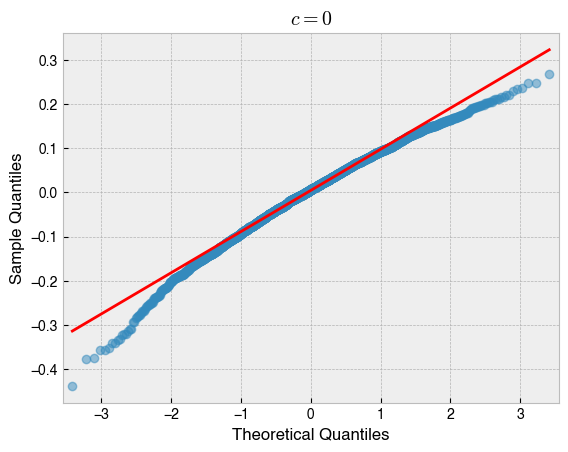

In [728]:
# from statsmodels.stats.diagnostic import het_white
# from statsmodels.stats.outliers_influence import OLSInfluence as olsi
# het_white(reswt.resid,X)
# res.get_robustcov_results(cov_type='HC0').pvalues
# studentized_residuals = olsi(reswt).resid_studentized
# leverage_pts = olsi(reswt).hat_matrix_diag
# cook_dist = olsi(reswt).cooks_distance

# sm.graphics.influence_plot(reswt, alpha  = 1e-6, criterion="cooks", plot_alpha=0.5)
# k = 61; x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1; y = int(k - 0.5*x*(x-1)); print(x, y)
# sns.residplot(x=X, y=emp_dist, lowess=True, color='grey'); 
# plt.plot(fit_dist,reswt.resid,'ko',alpha=0.3); plt.plot(fit_dist,res.resid,'bx',alpha=0.3)
# sm.OLS(emp_dist/fit_dist, fit_dist).fit().summary()
# plt.plot(emp_dist/fit_dist,fit_dist,'ko',alpha=0.3); 
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko'); plt.axhline(np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),color='grey'); plt.title(r'$c=0$'); plt.axhline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--'); plt.xlabel('fit dist'); plt.ylabel('emp dist/fit dist')
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko'); plt.axhline(np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),color='grey'); plt.title(r'$c=0$'); plt.axhline(-3*np.std(emp_dist/fit_dist),color='grey',ls='--'); plt.xlabel('fit dist'); plt.ylabel('emp dist/fit dist')
# plt.hist(emp_dist/fit_dist-np.mean(emp_dist/fit_dist),15,color='grey'); plt.axvline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--')
# np.where(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)<-3*np.std(emp_dist/fit_dist))
# sm.qqplot(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),line='q',alpha=0.5); plt.title(r'$c=0$'); 
# sm.qqplot(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),loc=0,scale=np.std(np.log(emp_dist/fit_dist)),line='q',alpha=0.5); plt.title(r'$c=0.5$');
# plt.hist(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),15,color='grey'); plt.axvline(-4*np.std(np.log(emp_dist/fit_dist)),color='grey',ls='--')

# sp.stats.norm.cdf(np.min(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.std(emp_dist/fit_dist))

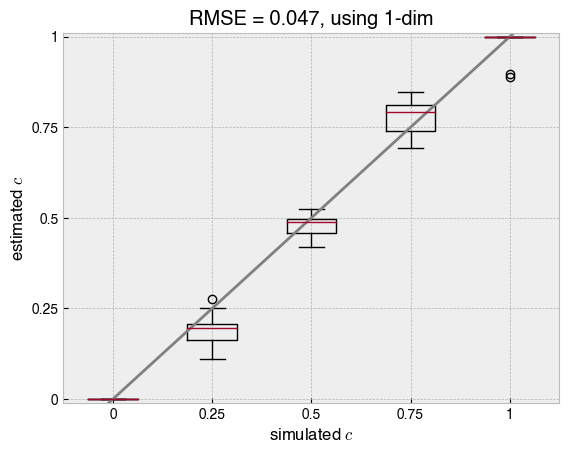

In [269]:
# plt.boxplot(estcR2mat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = %.3f, joint optim w/ $L^{-1} M L^{-1,T}$'%np.round(np.sqrt(np.mean((estcR2mat-np.array([0,0.25,0.5,0.75,1]))**2)),3)); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show() #plt.axline((1,0),slope=0.25,color='grey'); 
plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = {}, using 1-dim'.format(np.round(np.sqrt(np.mean((estcllmat-np.array([0,0.25,0.5,0.75,1]))**2)),3))); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.axline((1,0),slope=0.25,color='grey'); 
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('p-value'); plt.axhline(1e-4,color='grey',ls='--'); plt.semilogy(); plt.title('top outlier edge')
# np.sum(estcllmat[:,0]<5e-3)
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('LL(correct) - LL(wrong)'); plt.axhline(1.,color='grey',ls='--'); 

# df = pd.DataFrame(np.random.rand(32,5), columns=[0,0.25,0.5,0.75,1])
# df['E'] = [r'joint optim, RMSE$ = 0.19$']*16+[r'stepwise optim, RMSE$ = 0.04$']*16
# df.iloc[:16,:5] = estcR2mat
# df.iloc[16:,:5] = estcllmat
# sns.violinplot(df.melt(id_vars=['E'], value_vars=[0,0.25,0.5,0.75,1]), cut=0, inner='box',x='variable', y='value', hue='E', palette='Set2'); plt.xlabel(r'simulated $c$'); plt.legend(loc='upper left'); plt.ylabel(r'estimated $c$'); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show()

In [ ]:
# lamb_grid = np.geomspace(1e-1,100,10,endpoint=True)[::-1]
# cvq_err = run_cv_joint(sp_graph, lamb_grid=lamb_grid, lamb_q_grid=lamb_grid)
# print(lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,2)))], lamb_grid[np.argmin(np.mean(cvq_err,axis=(0,1)))])
# plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,1)),'k-o',label=r'$\lambda_w$'); plt.xlabel('values'); plt.ylabel('LOO CV error'); plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 
# sp_graph = Joint_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def, long_range_edges=[(8,27)],c=0.2);
# sp_graph.fit(lamb=3.,optimize_q='n-dim',option='joint',lamb_q=3.,alpha_q=.3); sp_graph.c
# sp.optimize.minimize_scalar(get_grad_FEEMS_demes_nll_w_c,args=({'sp_graph':sp_graph,'obj':obj,'lrn':lrn}),bounds=(0,1),method='bounded').x

### Including unobserved demes in the calculation of the likelihood 

Currently, I assume that all nodes in my grid are observed demes. But this is obviously not the case in real data. So I include a minimal working example with unobserved demes to ensure correct bookkeeping in my code. 

**NEW**: We want to be able to include unsampled demes as a potential source. 

In [ ]:
# def comp_fst_mat(genotypes, n_inds, n_demes):
#     """Computes an Fst distance matrix from a sample
#     genotype matrix and set of sub-population ids
#     """
#     n_snps = genotypes.shape[1]
#     acs = np.empty((n_demes, n_snps, 2))
    
#     # compute allele counts
#     for i in range(n_demes):
#         Gi = genotypes[np.arange(i*n_inds,(i+1)*n_inds), :]
#         acs[i, :, 0] = np.sum(Gi, axis=0)
#         acs[i, :, 1] = (2 * Gi.shape[0]) - np.sum(Gi, axis=0) 
    
#     # compute Fst matrix
#     Fst = np.empty((n_demes, n_demes))
#     for i in range(n_demes):
#         for j in range(n_demes):
#             Fst[i, j] = np.sum(allel.mean_pairwise_difference_between(acs[i, :, :].astype(np.int32), acs[j, :, :].astype(np.int32)))/n_snps

#     for i in range(n_demes):
#         Fst[i, i] = np.sum(allel.mean_pairwise_difference(acs[i, :, :].astype(np.int32)))/n_snps
#     return(Fst)

# Fst = comp_fst_mat(gen_test_80_adm,20,80)
# plt.hist(np.ravel(Fst))
# plt.imshow(Fst,cmap='RdBu_r'); plt.colorbar()